# 教師なし学習

教師なし学習における課題は訓練例として与えられるラベルなしのデータ$\{x_n\}$からその隠れた構造を推測することです。

ここではEdwardでの例を示します。Jupyter notebookでの原文は
[ここ](http://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/unsupervised.ipynb)にあります。

In [10]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import six
import tensorflow as tf

from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma,
    MultivariateNormalDiag, Normal, ParamMixture)

plt.style.use('ggplot')

# Data

2次元の模擬データ点集合$x_n \in R^2$を用います。

In [12]:
def build_toy_dataset(N):
  pi = np.array([0.4, 0.6])
  mus = [[1, 1], [-1, -1]]
  stds = [[0.1, 0.1], [0.1, 0.1]]
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

  return x

N = 500  # データ点の数
K = 2  # 要素数
D = 2  # データの次元
ed.set_seed(42)

x_train = build_toy_dataset(N)

このデータ点を可視化します。

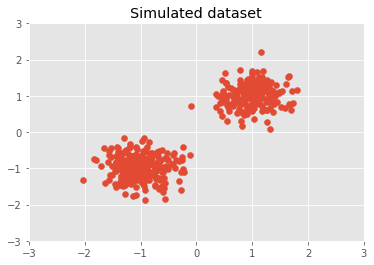

In [13]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.title("Simulated dataset")
plt.show()

# Model

混合モデルはクラスタリングのためによく使われます。これは混合分布の要素を各データ点に割り振るものです。
そして混合分布の要素はデータが生成されるであろう分布も決定します。
ガウス分布の混合はこのデータを生成するためにガウス分布を用います(Bishop, 2006)。

N個のデータ点に対し各観測値$\{x_n\}$に対する尤度は

\begin{align*}
  p(\mathbf{x}_n \mid \pi, \mu, \sigma)
  &=
  \sum_{k=1}^K \pi_k \, \text{Normal}(\mathbf{x}_n \mid \mu_k, \sigma_k).
\end{align*}


と書かれます。隠れた変数$\pi$は個々のガウス分布を混合するK次元確率変数のベクトルで、
それぞれは平均$\mu_k$ と標準偏差$\sigma_k$で特徴付けられます。

$\pi\in[0,1]$ 上の事前分布を以下のように$\sum_{k=1}^K\pi_k=1$ となるように定義します。

\begin{align*}
  p(\pi)
  &=
  \text{Dirichlet}(\pi \mid \alpha \mathbf{1}_{K})
\end{align*}


ここで$\alpha=1$に固定します。各要素上の事前分布は$\mathbf{\mu}_k\in\mathbb{R}^D$
に対して

\begin{align*}
  p(\mathbf{\mu}_k)
  &=
  \text{Normal}(\mathbf{\mu}_k \mid \mathbf{0}, \mathbf{I}).
\end{align*}


と定義し、$\mathbf{\sigma}_k^2\in\mathbb{R}^D$に対しては 

\begin{align*}
  p(\mathbf{\sigma}_k^2)
  &=
  \text{InverseGamma}(\mathbf{\sigma}_k^2 \mid a, b).
\end{align*}

と定義します。

ここでは２つのバージョンのモデルをEdwardで描きます。一つは混合の割り当て$c_n\in\{0,\ldots,K-1\}$を隠れた変数としたもの(結合バージョン)で、もう一つはそれを足し合わせたものです。

1つ目の結合バージョンは混合の割り当てを隠れた変数として明示的に含みます。我々はこれをランダムな変数`ParamMixture`を使って実装します。これは入力として混合確率、混合される要素のパラメータ 、要素の従う確率分布をとります。これは混合の割り当て上に定義された混合の条件付き分布です。

(これらを別々に書くことができ、最初にzとして`Categorical`ランダム変数を作り、次にxを`ParamMixture`で作ります。これは`tf.gather`を必要とせずより効率的であることに注意)


In [14]:
pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

(もう一つの)潰した(collapsed)方のバージョンは混合の割り当てを周辺化したものです。我々はこれをランダム変数`Mixture`を使って実装します。
これは入力としてカテゴリカル分布と各要素の分布のリストをとります。
これは混合の割り当てを足し合わせた混合の分布です。
ギブスサンプリングはランダム変数`Mixture`に対しては動かないので他の方法を使って下さい。

In [ ]:
"""
pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
cat = Categorical(probs=pi, sample_shape=N)
components = [
    MultivariateNormalDiag(mu[k], tf.sqrt(sigmasq[k]), sample_shape=N)
    for k in range(K)]
x = Mixture(cat=cat, components=components)
"""

ここでは結合バージョンの方を使います。

# 推測

モデル内のそれぞれの分布は共役事前分布を使って書かれます。これによってギブスサンプリングを使うことが出来ます。
これはそれぞれの分布の完全な条件付き分布から値を抽出することを繰り返すことでマルコフ連鎖モンテカルロ法を実施できます。すなわちそれぞれの分布は以前に抽出された値によって条件付けられています。

最初にサンプルの集まりを使って事後分布を近似する経験(empirial)ランダム変数を作ります。

In [15]:
T = 500  # number of MCMC samples
qpi = Empirical(tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(tf.Variable(tf.zeros([T, K, D])))
qsigmasq = Empirical(tf.Variable(tf.ones([T, K, D])))
qz = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))

ギブスサンプリングを走らせます。
ここではサンプリングの過程としてクラスター平均を取り出すために訓練ループを明示的に書きます。

In [16]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  if t % inference.n_print == 0:
    print("\nInferred cluster means:")
    print(sess.run(running_cluster_means, {t_ph: t - 1}))

  5/500 [  1%]                                ETA: 86s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.19850013 -0.14776745]
 [ 0.36547223  0.08249334]]
 10/500 [  2%]                                ETA: 48s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.18154746 -0.17103794]
 [ 0.68000132  0.5023486 ]]
 15/500 [  3%]                                ETA: 33s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.33901405 -0.31272894]
 [ 0.80011016  0.70811087]]
 20/500 [  4%] █                              ETA: 27s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.51785529 -0.48153058]
 [ 0.85121959  0.79478776]]
 25/500 [  5%] █                              ETA: 23s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.62494296 -0.584288  ]
 [ 0.87728256  0.84435129]]
 30/500 [  6%] █                              ETA: 20s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.69105101 -0.65279663]
 [ 0.89335829  0.87450618]]
 35/500 [  7%] ██                             

265/500 [ 53%] ███████████████                ETA: 4s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.97785139 -0.93644905]
 [ 0.97283739  1.00574934]]
270/500 [ 54%] ████████████████               ETA: 4s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.97867489 -0.93688768]
 [ 0.97351676  1.00600529]]
275/500 [ 55%] ████████████████               ETA: 4s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.9792546  -0.93772173]
 [ 0.97383004  1.00613415]]
280/500 [ 56%] ████████████████               ETA: 4s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.97981751 -0.93834585]
 [ 0.97394311  1.00647378]]
285/500 [ 56%] █████████████████              ETA: 4s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.98035902 -0.93883115]
 [ 0.9741416   1.00660813]]
290/500 [ 57%] █████████████████              ETA: 3s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.98072779 -0.9393664 ]
 [ 0.97433442  1.00688815]]
295/500 [ 59%] █████████████████              ETA: 3

# Criticism

それぞれのデータ点がどこに所属するか予測された結果を可視化します。

それぞれのデータ点に対しもっとも高い事後予測密度を作るクラスターへのとして割り当てを選びます。

これを行うためにまず事後分布からサンプルを抽出し、
データ点$\mathbf{x}_n$とクラスターへの割当て$k$に関する対数尤度の$N\times K$行列を計算します。
100個の事後分布からのサンプルの平均値を求めます。

In [17]:
#それぞれのデータ点とクラスターへの割り当てに対する尤度を計算する
#多くの事後分布からのサンプルに対する平均を計算する。``x_post``は(N, 100, K, D)という形
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

#隠れた変数の次元に関して和をとり、事後分布のサンプルに対して平均する。
# ``log_liks`` は (N, K)という形になる。
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

そして列(クラスターへの割り当て)に対して$\arg\max$を取ります。

In [18]:
#それぞれのデータ点に対してもっとも高い尤度のクラスターを選ぶ
clusters = tf.argmax(log_liks, 1).eval()

予測されたクラスターへの所属に応じて色付けしてデータ点をプロットします。

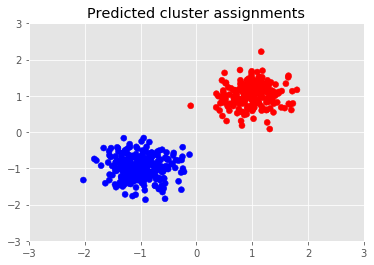

In [20]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

このモデルは正しくデータを分類しているようです。

# 補足: log-sum-exp trick

潰された混合モデルにおいて対数密度(log density)を実装するのはトリッキーです。

一般には対数密度は

\begin{align*}
  \log p(\pi) +
  \Big[ \sum_{k=1}^K \log p(\mathbf{\mu}_k) + \log
  p(\mathbf{\sigma}_k) \Big] +
  \sum_{n=1}^N \log p(\mathbf{x}_n \mid \pi, \mu, \sigma),
\end{align*}

ここで尤度は

\begin{align*}
  \sum_{n=1}^N \log p(\mathbf{x}_n \mid \pi, \mu, \sigma)
  &=
  \sum_{n=1}^N \log \sum_{k=1}^K \pi_k \, \text{Normal}(\mathbf{x}_n \mid
  \mu_k, \sigma_k).
\end{align*}

数値計算における不安定性を防ぐためにこの計算を対数スケールで行います。

\begin{align*}
  \sum_{n=1}^N \log p(\mathbf{x}_n \mid \pi, \mu, \sigma)
  &=
  \sum_{n=1}^N \log \sum_{k=1}^K \exp\Big(
  \log \pi_k + \log \text{Normal}(\mathbf{x}_n \mid \mu_k, \sigma_k)\Big).
\end{align*}

この式はlog sum expの操作を含みます。これは指数関数の操作は一つの(因子の)値が他と比べて支配的になってしまうので数値計算的に不安定です。それゆえlog-sum-expトリックを使います。

これは以下の恒等式に基づきます。

\begin{align*}
  \mathbf{x}_{\mathrm{max}}
  &=
  \arg\max \mathbf{x},
  \\
  \log \sum_i \exp(\mathbf{x}_i)
  &=
  \log \Big(\exp(\mathbf{x}_{\mathrm{max}}) \sum_i \exp(\mathbf{x}_i -
  \mathbf{x}_{\mathrm{max}})\Big)
  \\
  &=
  \mathbf{x}_{\mathrm{max}} + \log \sum_i \exp(\mathbf{x}_i -
  \mathbf{x}_{\mathrm{max}}).
\end{align*}

 log-sum-expを計算する前に最大値を引いておくことでより数値計算的に安定した出力が導かれます。
 ランダム変数$\texttt{Mixture}$の実装では対数密度を計算するのにこのトリックを使っています。